In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
%matplotlib inline

## Starting off with a Linear SVM

In [5]:
data1 = loadmat('../Data/ex6data1.mat')
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [6]:
X = data1['X']
y = data1['y']

This is classification data, so X provides two features and y provides the class, 0 or 1.

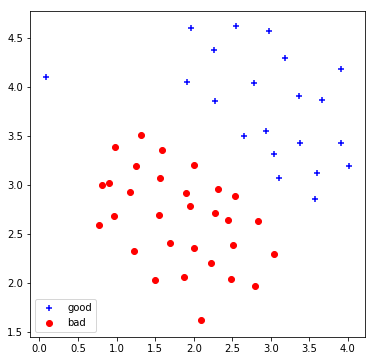

In [7]:
plt.figure(figsize=[6,6])
plt.scatter(X[y.ravel()==1,0],X[y.ravel()==1,1],c='b',marker='+',label='good')
plt.scatter(X[y.ravel()==0,0],X[y.ravel()==0,1],c='r',marker='o',label='bad')
plt.legend(loc=3)
plt.show()

Looks like there's one outlier, so the first task is to see how this affects the SVM. For this exercise, we are not asked to design our own implementation, so I'll be using the sklearn implementation, as usual.

While it's not explicit in the directions, I'll start with a linear SVM, and move up from there on the next exercise.

In [8]:
from sklearn.svm import LinearSVC

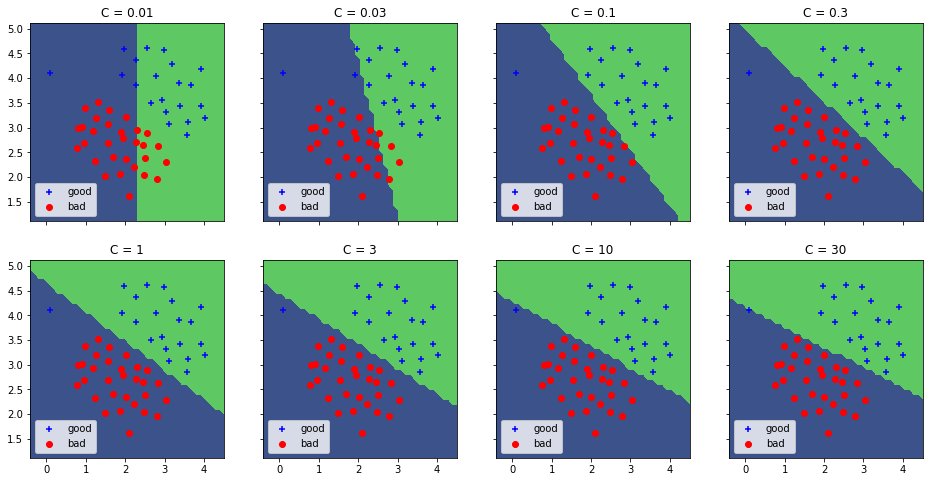

In [9]:
C_list = [.01, .03, .1, .3, 1, 3, 10, 30]
fig, ax = plt.subplots(2,4,figsize=[16,8], sharex=True, sharey=True)
ax = ax.flatten()
x1, x2 = np.meshgrid(np.linspace(X[:,0].min()-1,X[:,0].max()+1),np.linspace(X[:,1].min()-1,X[:,1].max()+1))
for iC, C in enumerate(C_list):
    svc = LinearSVC(dual=False,C=C)
    svc.fit(X,y.ravel())
    P = svc.predict(np.c_[x1.ravel(),x2.ravel()])
    P = P.reshape(x1.shape)
    ax[iC].contourf(x1,x2,P, levels=[0, .5, 1])
    ax[iC].scatter(X[y.ravel()==1,0],X[y.ravel()==1,1],c='b',marker='+',label='good')
    ax[iC].scatter(X[y.ravel()==0,0],X[y.ravel()==0,1],c='r',marker='o',label='bad')
    ax[iC].set_title(f'C = {C}')
    ax[iC].legend(loc=3)
    ax[iC].set_xlim((X[:,0].min()-.5,X[:,0].max()+.5))
    ax[iC].set_ylim((X[:,1].min()-.5,X[:,1].max()+.5))
plt.show()

The regularization plays a very important role when there are outliers. Even if there aren't, very low C makes for a very bad fit.

## Now to explore Gaussian kernels

In [10]:
data2 = loadmat('../Data/ex6data2.mat')
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [11]:
X = data2['X']
y = data2['y']

This is classification data, so X provides two features and y provides the class, 0 or 1.

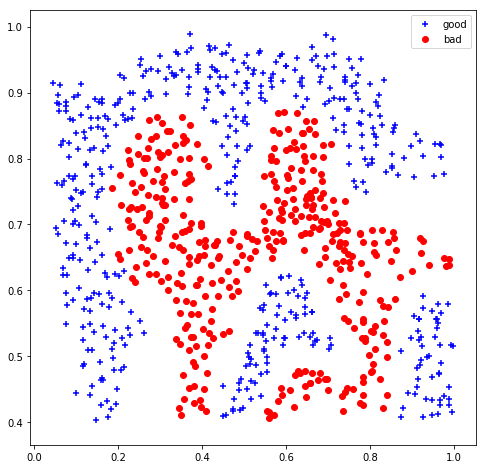

In [12]:
plt.figure(figsize=[8,8])
plt.scatter(X[y.ravel()==1,0],X[y.ravel()==1,1],c='b',marker='+',label='good')
plt.scatter(X[y.ravel()==0,0],X[y.ravel()==0,1],c='r',marker='o',label='bad')
plt.legend(loc=0)
plt.show()

This is a complex shape, so we definitely can't use a linear SVM. Time for a Gaussian kernel. I misunderstood that the 'rbf' kernel was exactly what I wanted, so I spent a lot of time trying to implement my own Gaussin kernel. As such, I'm leaving that work here and comparing it with the 'rbf' kernel next.

In [13]:
from sklearn.svm import SVC

Before moving forward with the gaussian implementation, it's important to scale the data with zero mean, so I'm going to try to use the sklearn implementation for that.

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler().fit(X)
scaleX = scaler.transform(X)

In [16]:
def selfDistanceSquaredMatrix(X):
    # X should be an (m,n) matrix with m examples and n dimentions/features
    tmp = X.reshape(X.shape[0],1,X.shape[1]) # This is important because np.dot works on the last axis
    return np.dot((tmp - np.transpose(tmp,axes=(1,0,2)))**2,np.ones(X.shape[1]))

def dataDistanceSquaredMatrix(data,rel):
    tmp1 = data.reshape(1,data.shape[0],data.shape[1])
    tmp2 = rel.reshape(rel.shape[0],1,rel.shape[1])
    return np.dot((tmp1 - tmp2)**2,np.ones(data.shape[1]))

def gaussian_gram(distX,sigma):
    return np.exp(-distX/(2*sigma**2))

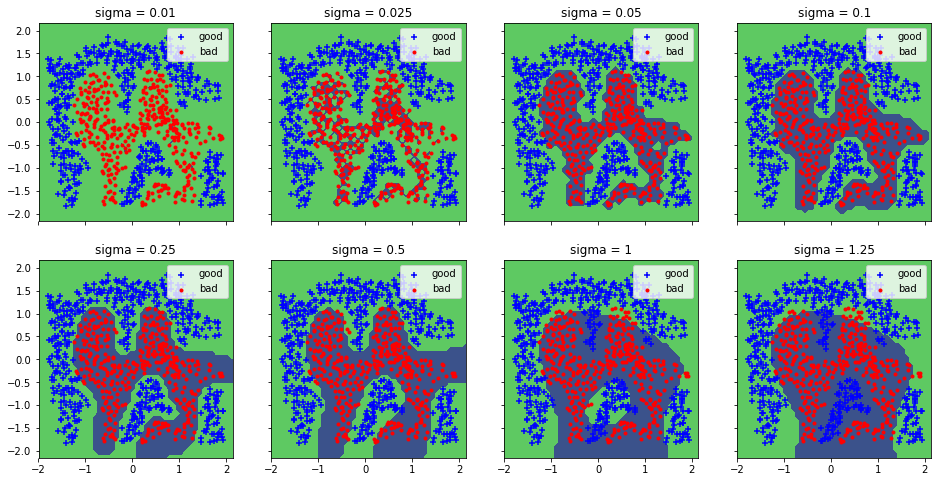

In [30]:
sigma_list = [.01, .025, .05, .1, .25, .5, 1, 1.25 ]
fig, ax = plt.subplots(2,4,figsize=[16,8], sharex=True, sharey=True)
ax = ax.flatten()
edge = .05
min_x1, max_x1, min_x2, max_x2 = (X[:,0].min()-edge, X[:,0].max()+edge, X[:,1].min()-edge, X[:,1].max()+edge)
grid_size = (50,50)
x1, x2 = np.meshgrid(np.linspace(min_x1,max_x1,grid_size[0]),np.linspace(min_x2,max_x2,grid_size[1]))
tmp = scaler.transform(np.c_[x1.ravel(),x2.ravel()])
x1 = tmp[:,0].reshape(grid_size)
x2 = tmp[:,1].reshape(grid_size)
for isig, sigma in enumerate(sigma_list):
    svc = SVC(kernel='precomputed')
    svc.fit(gaussian_gram(selfDistanceSquaredMatrix(scaleX),sigma),y.ravel())
    P = svc.predict(gaussian_gram(dataDistanceSquaredMatrix(scaleX,np.c_[x1.ravel(),x2.ravel()]),sigma))
    P = P.reshape(grid_size)
    ax[isig].contourf(x1,x2,P, levels=[0, .5, 1])
    ax[isig].scatter(scaleX[y.ravel()==1,0],scaleX[y.ravel()==1,1],c='b',marker='+',label='good')
    ax[isig].scatter(scaleX[y.ravel()==0,0],scaleX[y.ravel()==0,1],c='r',marker='.',label='bad')
    ax[isig].set_title(f'sigma = {sigma}')
    ax[isig].legend(loc=0)
plt.show()

Well, in a monumental effort of doing too much, I figured out how to do a custom kernel. Here it looks like a sigma of 0.1 does the best job of fitting the data. For the standard 'rbf' kernel that would translate to a gamma of 50, so let's see if I get the same thing when I do that.

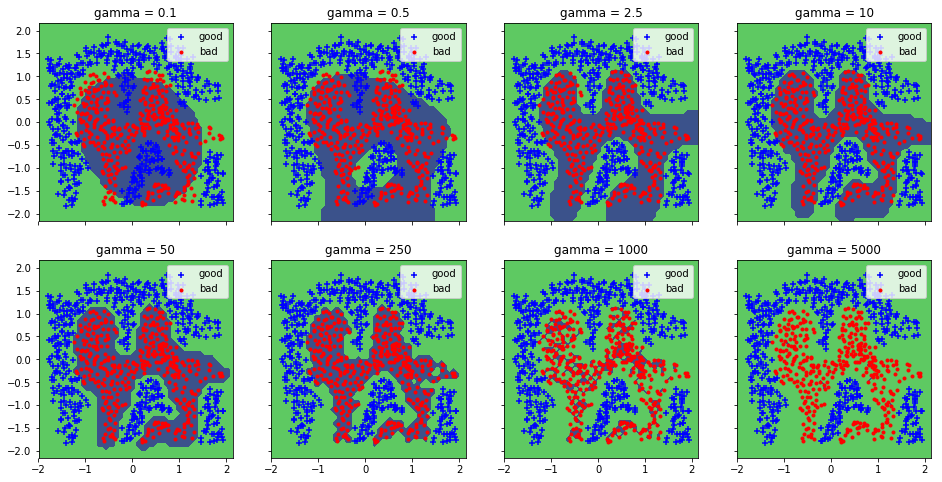

In [33]:
gamma_list = [.1, .5, 2.5, 10, 50, 250, 1000, 5000]
fig, ax = plt.subplots(2,4,figsize=[16,8], sharex=True, sharey=True)
ax = ax.flatten()
edge = .05
min_x1, max_x1, min_x2, max_x2 = (X[:,0].min()-edge, X[:,0].max()+edge, X[:,1].min()-edge, X[:,1].max()+edge)
grid_size = (50,50)
x1, x2 = np.meshgrid(np.linspace(min_x1,max_x1,grid_size[0]),np.linspace(min_x2,max_x2,grid_size[1]))
tmp = scaler.transform(np.c_[x1.ravel(),x2.ravel()])
x1 = tmp[:,0].reshape(grid_size)
x2 = tmp[:,1].reshape(grid_size)
for igam, gamma in enumerate(gamma_list):
    svc = SVC(gamma=gamma,kernel='rbf')
    svc.fit(scaleX,y.ravel())
    P = svc.predict(np.c_[x1.ravel(),x2.ravel()])
    P = P.reshape(grid_size)
    ax[igam].contourf(x1,x2,P, levels=[0, .5, 1])
    ax[igam].scatter(scaleX[y.ravel()==1,0],scaleX[y.ravel()==1,1],c='b',marker='+',label='good')
    ax[igam].scatter(scaleX[y.ravel()==0,0],scaleX[y.ravel()==0,1],c='r',marker='.',label='bad')
    ax[igam].set_title(f'gamma = {gamma}')
    ax[igam].legend(loc=0)
plt.show()

My prediction was correct. Gamma of 50 matches very well to my eye with sigma of 0.1. And this code ran significantly faster than my custom code. At least a good chunck of my wasted time was spent figuring out how to deal with scaling, which was important for the 'rbf' implementation as well.

## Example 3, more of the same

In [34]:
data3 = loadmat('../Data/ex6data3.mat')
data3.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'yval', 'Xval'])

In [35]:
X = data3['X']
y = data3['y']
Xval = data3['Xval']
yval = data3['yval']

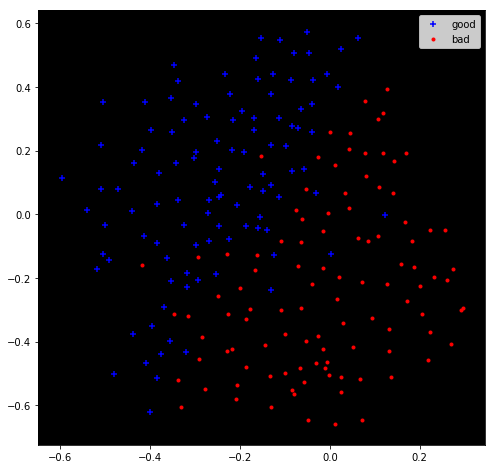

In [39]:
plt.figure(figsize=[8,8])
plt.axes(facecolor='k')
plt.scatter(X[y.ravel()==1,0],X[y.ravel()==1,1],c='b',marker='+',label='good')
plt.scatter(X[y.ravel()==0,0],X[y.ravel()==0,1],c='r',marker='.',label='bad')
plt.legend(loc=0)
plt.show()

The time we have some validation data, so I can assume we're going to try to find the best parameters using that.

In [40]:
scaler = StandardScaler().fit(X)
scaleX = scaler.transform(X)

In [49]:
gamma_list = [.1, .5, 2.5, 10, 50, 250, 1000, 5000]
C_list = [.01, .03, .1, .3, 1, 3, 10, 30, 100]
accuracy = np.zeros((len(gamma_list),len(C_list)))
for igam, gamma in enumerate(gamma_list):
    for iC, C in enumerate(C_list):
        svc = SVC(gamma=gamma, kernel='rbf', C=C)
        svc.fit(scaleX,y.ravel())
        P = svc.predict(scaler.transform(Xval))
        accuracy[igam,iC] = 100*sum(P==yval.ravel())/yval.size

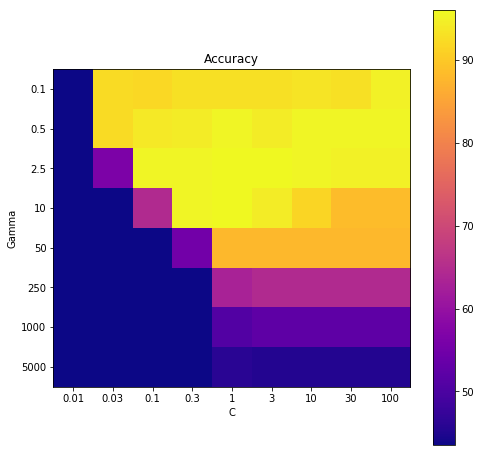

In [52]:
plt.figure(figsize=[8,8])
plt.imshow(accuracy, cmap=plt.get_cmap('plasma'))
plt.colorbar()
plt.xticks(range(len(C_list)),[str(C) for C in C_list])
plt.xlabel('C')
plt.yticks(range(len(gamma_list)),[str(gamma) for gamma in gamma_list])
plt.ylabel('Gamma')
plt.title('Accuracy')
plt.show()

Zooming in on that promising region.

In [68]:
gamma_list = [10**(n/6) for n in range(-8,8)]
C_list = [10**(n/6) for n in range(-8,25)]
accuracy = np.zeros((len(gamma_list),len(C_list)))
for igam, gamma in enumerate(gamma_list):
    for iC, C in enumerate(C_list):
        svc = SVC(gamma=gamma, kernel='rbf', C=C)
        svc.fit(scaleX,y.ravel())
        P = svc.predict(scaler.transform(Xval))
        accuracy[igam,iC] = 100*sum(P==yval.ravel())/yval.size

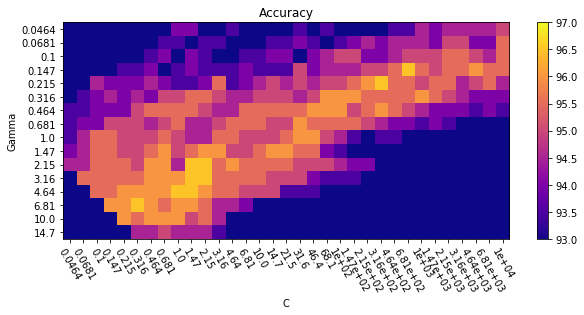

In [73]:
plt.figure(figsize=[10,4])
plt.imshow(accuracy, cmap=plt.get_cmap('plasma'),vmin=93,vmax=97)
plt.colorbar()
plt.xticks(range(len(C_list)),[f'{C:.3}' for C in C_list],rotation=-60)
plt.xlabel('C')
plt.yticks(range(len(gamma_list)),[f'{gamma:.3}' for gamma in gamma_list])
plt.ylabel('Gamma')
plt.title('Accuracy')
plt.show()

Looks like there's a pretty wide range of acceptability. It seems like there are some isolated peaks, so I'm going to go with the bright chunk that looks biggest. 

In [74]:
C_opt = 2
gamma_opt = 3

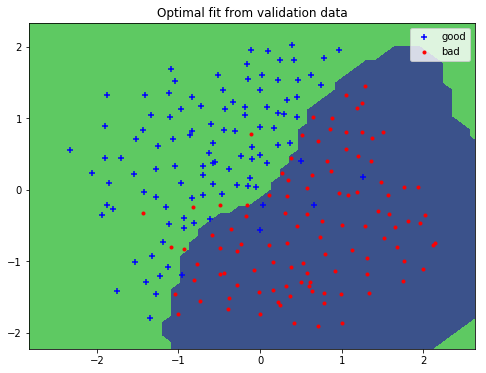

In [77]:
plt.figure(figsize=[8,6])
edge = .1
min_x1, max_x1, min_x2, max_x2 = (X[:,0].min()-edge, X[:,0].max()+edge, X[:,1].min()-edge, X[:,1].max()+edge)
grid_size = (50,50)
x1, x2 = np.meshgrid(np.linspace(min_x1,max_x1,grid_size[0]),np.linspace(min_x2,max_x2,grid_size[1]))
tmp = scaler.transform(np.c_[x1.ravel(),x2.ravel()])
x1 = tmp[:,0].reshape(grid_size)
x2 = tmp[:,1].reshape(grid_size)
svc = SVC(gamma=gamma_opt, kernel='rbf', C=C_opt)
svc.fit(scaleX,y.ravel())
P = svc.predict(np.c_[x1.ravel(),x2.ravel()])
P = P.reshape(grid_size)
plt.contourf(x1,x2,P, levels=[0, .5, 1])
plt.scatter(scaleX[y.ravel()==1,0],scaleX[y.ravel()==1,1],c='b',marker='+',label='good')
plt.scatter(scaleX[y.ravel()==0,0],scaleX[y.ravel()==0,1],c='r',marker='.',label='bad')
plt.legend(loc=0)
plt.title('Optimal fit from validation data')
plt.show()

# Spam Classification
On to the real meat.

In [79]:
dataTest = loadmat('../Data/spamTest.mat')
dataTest.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Xtest', 'ytest'])

In [84]:
dataTrain = loadmat('../Data/spamTrain.mat')
dataTrain.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [86]:
X = dataTrain['X']
y = dataTrain['y']
Xtest = dataTest['Xtest']
ytest = dataTest['ytest']

In [87]:
print(f'X shape is {X.shape} and y shape is {y.shape}')
print(f'Xtest shape is {Xtest.shape} and ytest shape is {ytest.shape}')

X shape is (4000, 1899) and y shape is (4000, 1)
Xtest shape is (1000, 1899) and ytest shape is (1000, 1)


So it turns out there is an easy way and a hard way to do this exercise. The hard way involves fully fledged text analysis on a coprus that I can't actually find. So I'm going to take the easy way, and find a text analytics project (in fact I already have one in mind) to practice on later. For now, I'm just going to proceed with the info as it is already broken down.

#### Data processing

They start with the text of 5000 emails, splitting that into a 4000 train group and a 1000 test group. The text of the emails are simplified so that 
1. complex elements, like links, numbers, symbols, are turned into words
2. all the words are lowercase
3. all the words represent only the stems (i.e. suffix's removed: -ed -ing -s)
4. non-words and punctuation have been removed

From all this text, they compiled a list of all the unique words, and then picked all the words that occurred at least 100 times and turned that into a vocabulary list, which ended up being 1899 words long.

Each email can then be broken down into a vector of length 1899, where the elements signify if the corresponding word from the vocab list was there (1 or 0). This describes each row in the `X` variable. The `y` variable has 1 for spam and 0 for not-spam (I'm not
calling it ham).

In [ ]:
C_list = [.003, .01, .03, .1, .3, 1, 3, 10, 30]
accuracy = np.zeros(len(C_list))
for iC, C in enumerate(C_list):
    svc = SVC(kernel='linear', C=C)
    svc.fit(X,y.ravel())
    P = svc.predict(Xtest)
    accuracy[iC] = 100*sum(P==ytest.ravel())/ytest.size

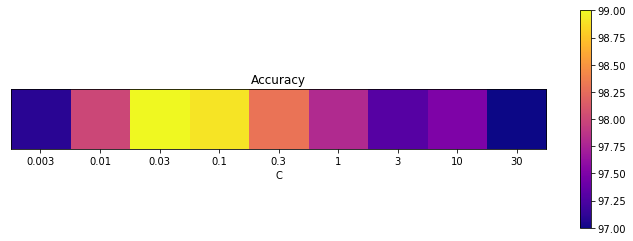

In [95]:
plt.figure(figsize=[12,4])
plt.imshow(accuracy.reshape(1,-1), cmap=plt.get_cmap('plasma'))
plt.colorbar()
plt.xticks(range(len(C_list)),[str(C) for C in C_list])
plt.xlabel('C')
plt.yticks([])
plt.title('Accuracy')
plt.show()

It appears the accuracy never really gets that bad. It also appears that spam detection really isn't that hard.

In [96]:
C_opt = .03

In [97]:
svc = SVC(kernel='linear', C=C_opt)
svc.fit(X,y.ravel())

SVC(C=0.03, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [99]:
svc.coef_

array([[ 0.00881197,  0.00775629,  0.0199348 , ..., -0.07217202,
        -0.00657756,  0.03463704]])

In [154]:
importantParams = np.argsort(svc.coef_).ravel()[::-1]

In [144]:
import re
vocab_list = []
with open('../Data/vocab.txt') as f:
    for line in f:
        m = re.search(r'(\d*)(\t)(.*)(\n)',line)
        vocab_list.append(m.group(3))

I feel like there must be a better way to build that vocab list than this, but this works, so I'm sticking with it.

And below we've got the 15 most influential words for determining spam. This is a bit different than what the instructions say, but still a decent amount of overlap.

In [157]:
for i in range(15):
    print(vocab_list[importantParams[i]])

click
remov
basenumb
our
guarante
visit
pleas
you
dollar
here
most
free
will
nbsp
multipart
